# Respect the ORIGIN! A Best-case Evaluation of Connection Coalescing in the Wild
---
##### Authors: _Sudheesh Singanamalla, Muhammad Talha Paracha, Suleman Ahmad Jonathan Hoyland, Luke Valenta, Yevgen Safronov, Peter Wu, Andrew Galloni, Kurtis Heimerl, Nick Sullivan, Christopher A. Wood, Marwan Fayed_
---
<img src="https://research.cloudflare.com/img/logo.svg" alt="Cloudflare Research" style="width: 250px;"/>

----

```latex
@inproceedings{
    author = {Singanamalla, Sudheesh and Paracha, Muhammad Talha and Ahmad, Suleman and Hoyland, Jonathan and Valenta, Luke and Safronov, Yevgen and Wu, Peter and Galloni, Andrew and Heimerl, Kurtis and Sullivan, Nick and Wood, Christopher A. and Fayed, Marwan}
    title = {Respect the ORIGIN! A Best-case Evaluation of Connection Coalescing in the Wild},
    year = {2022},
    isbn = {},
    publisher = {Association for Computing Machinery},
    address = {New York, NY, USA},
    url = {https://doi.org/},
    booktitle = {Proceedings of the Internet Measurement Conference},
    location = {Nice, France},
    series = {IMC '22}
}
```
or
```endnote
Sudheesh Singanamalla, Muhammad Talha Paracha, Suleman Ahmad, Jonathan Hoyland, Luke Valenta, Yevgen Safronov, Peter Wu, Andrew Galloni, Kurtis Heimerl, Nick Sullivan, Christopher A. Wood, Marwan Fayed. Respect the ORIGIN! A Best-case Evaluation of Connection Coalescing in the Wild. In ACM Internet Measurement Conference (IMC '22), October 25-27, 2022, Nice, France. ACM, New York, NY, USA, 15 pages. https://doi.org/
```

The following notebook contains references to the data necessary to reproduce each figure in the accompanying paper and is made available along with the raw data releases.

In [1]:
# Necessary Imports
%matplotlib inline

import os
from datetime import datetime
from operator import itemgetter

import pandas
import numpy

import matplotlib.pyplot as plt

import seaborn as sns
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings("ignore")

In [2]:
# The location of the raw dataframes
DATAFRAME_DIR = 'data'

In [3]:
# Helper method to compute the CDF of the given data
def _cdf(data, sort_needed=True):
    n = len(data)
    x = data
    if sort_needed:
        x = numpy.sort(data)  # sort your data
    y = numpy.arange(1, n + 1) / n  # calculate cumulative probability
    return x, y

## Figure 1: Frequency Distribution and CDF of number of Unique ASes needed to load a webpage.

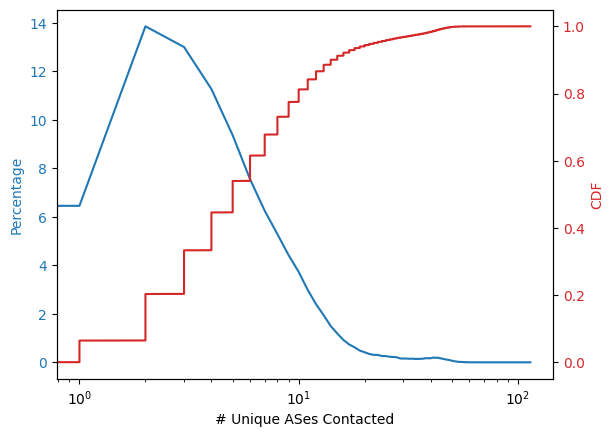

In [4]:
def plot_figure_1(
        asn_share_dataframe_path=f"{DATAFRAME_DIR}/figure-1-dataframe-asn-share.csv",
        cdf_dataframe_path=f"{DATAFRAME_DIR}/figure-1-dataframe-cdf.csv",
):
    df = pandas.read_csv(asn_share_dataframe_path)
    cdf_df = pandas.read_csv(cdf_dataframe_path)
    as_X = numpy.array(cdf_df['cdf-X'].tolist())
    as_Y = numpy.array(cdf_df['cdf-Y'].tolist())

    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax2 = ax.twinx()

    ax.plot(df["ASes"].tolist(), df["Count"].tolist(), color='tab:blue')
    ax2.plot(as_X, as_Y, color="tab:red")

    ax.set_xscale('log')
    ax.set_xlabel('# Unique ASes Contacted')
    ax.set_ylabel('Percentage', color="tab:blue")
    ax.tick_params(axis="y", labelcolor="tab:blue")
    plt.tick_params(axis="x", which="minor")

    ax2.set_ylabel('CDF', color="tab:red")
    ax2.tick_params(axis="y", labelcolor="tab:red")
    plt.show()

plot_figure_1()

## Figure 2: (Pre-rendered) Timeline of requests involved in page load time and reconstruction.

Please see the corresponding `.drawio` files which are XML files and can be opened through [this application](https://app.diagrams.net/)

![Timeline of requests involved in page load time and reconstruction](plots/figure-2.png)

## Figure 3 - Comparison of measured DNS, TLS to Ideal IP and ORIGIN Frame settings.

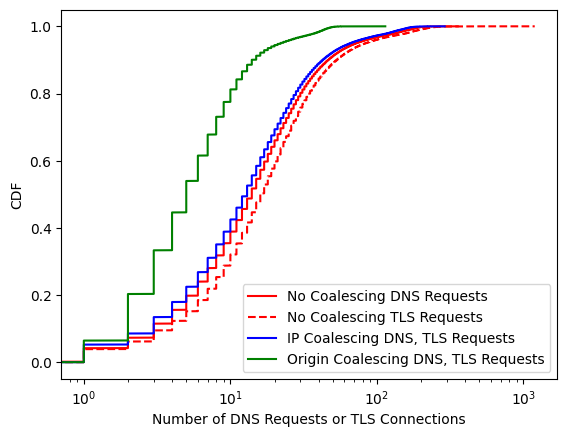

In [5]:
def plot_figure_3(dataframe_path=f"{DATAFRAME_DIR}/figure-3-dataframe.csv"):
    df = pandas.read_csv(dataframe_path)
    no_coalescing_dns_requests = numpy.array(df['dns'].tolist())
    no_coalescing_tls_requests = numpy.array(df['tls'].tolist())
    ip_coalescing_tls_dns_requests = numpy.array(df['ip_dns_tls'].tolist())
    origin_asn_coalescing_tls_dns_requests = numpy.array(df['origin_dns_tls'].tolist())
    fig, ax = plt.subplots(nrows=1, ncols=1)
    for arr, label_name, color, ltype in [(no_coalescing_dns_requests, 'No Coalescing DNS Requests', 'red', '-'),
                                          (no_coalescing_tls_requests, 'No Coalescing TLS Requests', 'red', '--'),
                                          (ip_coalescing_tls_dns_requests, 'IP Coalescing DNS, TLS Requests', 'blue',
                                           '-'),
                                          (
                                                  origin_asn_coalescing_tls_dns_requests,
                                                  'Origin Coalescing DNS, TLS Requests',
                                                  'green', '-')]:
        X, Y = _cdf(list(arr), sort_needed=True)
        ax.plot(X, Y, label=label_name, color=color, linestyle=ltype)
    ax.legend()
    ax.set_xscale('log')
    ax.set_xlabel('Number of DNS Requests or TLS Connections')
    ax.set_ylabel('CDF')
    plt.show()

plot_figure_3()

## Figure 4 - Comparison of DNS SAN names in existing certificates to proposed certificates.

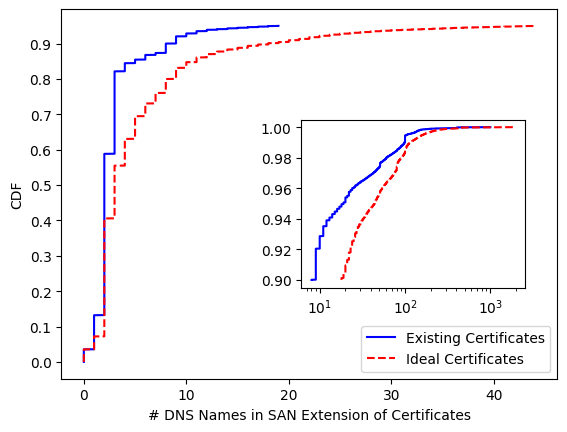

In [6]:
def plot_figure_4(dataframe_path=f"{DATAFRAME_DIR}/figure-4-dataframe.csv"):
    df = pandas.read_csv(dataframe_path)

    original_san_list = numpy.array(df['original_san_list'].tolist())
    updated_san_list = numpy.array(df['updated_san_list'].tolist())

    fig, ax = plt.subplots(nrows=1, ncols=1)
    left, bottom, width, height = [0.5, 0.3, 0.35, 0.35]
    ax_inset = fig.add_axes([left, bottom, width, height])
    for arr, label_name, color, ltype in [(original_san_list, 'Existing Certificates', 'blue', '-'),
                                          (updated_san_list, 'Ideal Certificates', 'red', '--')]:
        X, Y = _cdf(list(arr), sort_needed=True)
        X_in, Y_in = zip(*[(x, y) for x, y in list(zip(list(X), list(Y))) if y > 0.9])
        X_out, Y_out = zip(*[(x, y) for x, y in list(zip(list(X), list(Y))) if y <= 0.95])
        ax.plot(X_out, Y_out, label=label_name, color=color, linestyle=ltype)
        ax_inset.plot(X_in, Y_in, label=label_name, color=color, linestyle=ltype)
    ax.legend()
    ax.set_xlabel('# DNS Names in SAN Extension of Certificates')
    ax.set_ylabel('CDF')
    ax.set_yticks(numpy.arange(min(Y_out), max(Y_out), 0.1))
    ax_inset.set_xscale('log')
    plt.show()

plot_figure_4()

## Figure 5 - Tail distribution of number of SAN entries in certificates and changes needed.

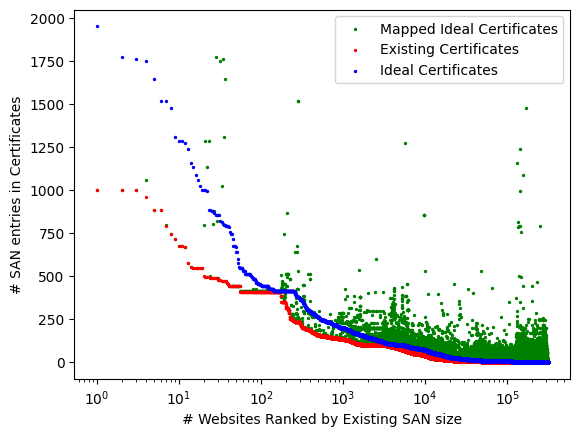

In [7]:
def plot_figure_5(dataframe_path=f"{DATAFRAME_DIR}/figure-5-dataframe.csv"):
    df = pandas.read_csv(dataframe_path)

    original_san_list = numpy.array(df['original_san_list'].tolist())
    updated_san_list = numpy.array(df['updated_san_list'].tolist())

    o_u_list = list(zip(original_san_list, updated_san_list))
    o_u_list = sorted(o_u_list, key=itemgetter(0), reverse=True)
    u_list = [x[1] for x in o_u_list]

    mapped_san_list = u_list

    fig, ax = plt.subplots(nrows=1, ncols=1)
    original = numpy.sort(original_san_list)[::-1]
    updated = numpy.sort(updated_san_list)[::-1]
    entries = numpy.arange(1, len(original) + 1)
    ax.scatter(entries, mapped_san_list, label='Mapped Ideal Certificates', color='green', s=2, rasterized=True)
    ax.scatter(entries, original, label='Existing Certificates', color='red', s=2, rasterized=True)
    ax.scatter(entries, updated, label='Ideal Certificates', color='blue', s=2, rasterized=True)
    ax.set_xscale('log')
    ax.set_xlabel('# Websites Ranked by Existing SAN size')
    ax.set_ylabel('# SAN entries in Certificates')
    ax.legend()
    plt.show()

plot_figure_5()

## Figure 6 - Certificate Issuance for Experimental Setup.

![Certificate Issuance for Experimental Setup.](plots/figure-6.png)

## Figure 7 - Connection reuse seen in live experiments with IP-Based, ORIGIN Frame coalescing.

(IP          ) [CONTROL   ] Size of NON Coalesced connections: 1716
(IP          ) [CONTROL   ] Points of change: [ 151 1581 1702 1708 1713]
(IP          ) [CONTROL   ] Points of change: [8.7995337995338, 92.13286713286713, 99.18414918414918, 99.53379953379954, 99.82517482517483]
(IP          ) [EXPERIMENT] Size of NON Coalesced connections: 1735
(IP          ) [EXPERIMENT] Points of change: [1210 1703 1731 1733]
(IP          ) [EXPERIMENT] Points of change: [69.7406340057637, 98.15561959654178, 99.76945244956772, 99.88472622478386]


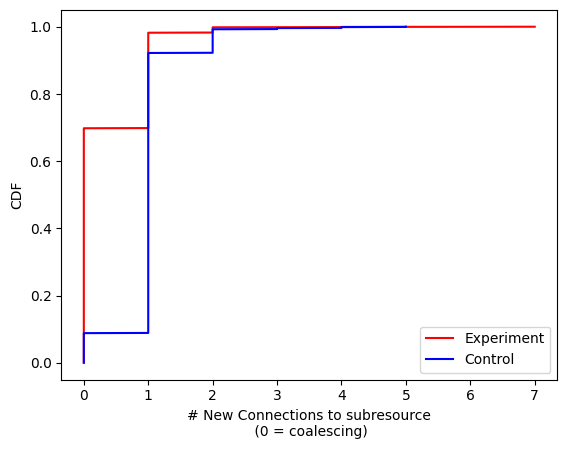

(Origin Frame) [CONTROL   ] Size of NON Coalesced connections: 1685
(Origin Frame) [CONTROL   ] Points of change: [  93 1519 1677 1682]
(Origin Frame) [CONTROL   ] Points of change: [5.519287833827893, 90.14836795252225, 99.52522255192878, 99.82195845697329]
(Origin Frame) [EXPERIMENT] Size of NON Coalesced connections: 1694
(Origin Frame) [EXPERIMENT] Points of change: [1085 1649 1690 1692]
(Origin Frame) [EXPERIMENT] Points of change: [64.0495867768595, 97.3435655253837, 99.76387249114522, 99.88193624557262]


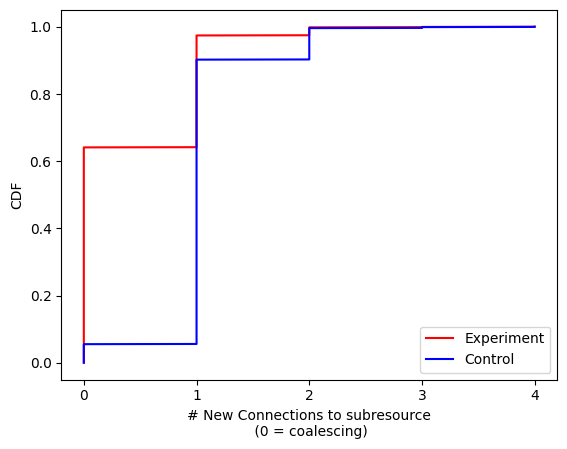

In [8]:
def plot_figure_7(
        a_dataframe_path=f"{DATAFRAME_DIR}/live_ip_coalescing_experiment_control.csv",
        b_dataframe_path=f"{DATAFRAME_DIR}/live_origin_coalescing_experiment_control.csv",
):
    for dataframe_path, experiment_mode, figure_name in [
        (a_dataframe_path, 'IP          ', 'figure-7a'),
        (b_dataframe_path, 'Origin Frame', 'figure-7b'),
    ]:
        df = pandas.read_csv(dataframe_path)
        exp_df = df[df['Type'] == 'Experiment']
        con_df = df[df['Type'] == 'Control']
        fig, ax = plt.subplots(nrows=1, ncols=1)
        exp_noncoalesced_connections = numpy.array(exp_df['CDNJS-Not-Coalesced'].tolist())
        exp_noncoalesced_connections.sort()
        # exp_coalesced_connections = numpy.array(exp_df['Total-TLS'].tolist())
        con_noncoalesced_connections = numpy.array(con_df['CDNJS-Not-Coalesced'].tolist())
        con_noncoalesced_connections.sort()
        # con_coalesced_connections = numpy.array(con_df['Total-TLS'].tolist())
        print(
            f'({experiment_mode}) [CONTROL   ] Size of NON Coalesced connections: {len(con_noncoalesced_connections)}')
        con_r = numpy.where(con_noncoalesced_connections[:-1] != con_noncoalesced_connections[1:])[0]
        exp_r = numpy.where(exp_noncoalesced_connections[:-1] != exp_noncoalesced_connections[1:])[0]
        print(f'({experiment_mode}) [CONTROL   ] Points of change: {con_r}')
        con_p = [x / len(con_noncoalesced_connections) * 100.0 for x in con_r]
        exp_p = [x / len(exp_noncoalesced_connections) * 100.0 for x in exp_r]
        print(f'({experiment_mode}) [CONTROL   ] Points of change: {con_p}')
        print(
            f'({experiment_mode}) [EXPERIMENT] Size of NON Coalesced connections: {len(exp_noncoalesced_connections)}')
        print(f'({experiment_mode}) [EXPERIMENT] Points of change: {exp_r}')
        print(f'({experiment_mode}) [EXPERIMENT] Points of change: {exp_p}')

        exp_x, exp_y = _cdf(exp_noncoalesced_connections)
        con_x, con_y = _cdf(con_noncoalesced_connections)
        ax.plot(exp_x, exp_y, label='Experiment', color='red')
        ax.plot(con_x, con_y, label='Control', color='blue')
        ax.legend()
        ax.set_xlabel('# New Connections to subresource\n (0 = coalescing)')
        ax.set_ylabel('CDF')
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show()

plot_figure_7()

## Figure 8 - Reduction in Number of TLS connections in ORIGIN Frame experiments

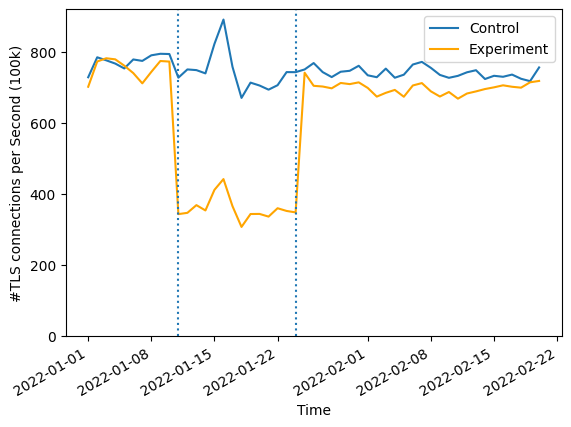

In [9]:
def plot_figure_8(control_timeline=f"{DATAFRAME_DIR}/origin_frame_control_timeline.csv",
                  experiment_timeline=f"{DATAFRAME_DIR}/origin_frame_experiment_timeline.csv"):
    con_df = pandas.read_csv(control_timeline)
    exp_df = pandas.read_csv(experiment_timeline)
    con_df['Time'] = pandas.to_datetime(con_df['Time'], infer_datetime_format=True)
    exp_df['Time'] = pandas.to_datetime(exp_df['Time'], infer_datetime_format=True)

    fig, ax = plt.subplots(nrows=1, ncols=1)
    sns.lineplot(x="Time", y="Count", label='Control', data=con_df)
    sns.lineplot(x="Time", y="Count", label='Experiment', data=exp_df, color='orange')
    ax.legend()
    ax.axvline(x=datetime(day=11, month=1, year=2022), linestyle=':')
    ax.axvline(x=datetime(day=24, month=1, year=2022), linestyle=':')
    ax.set_ylabel('#TLS connections per Second (100k)')
    ax.set_xlabel('Time')
    fig.get_figure().autofmt_xdate()
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.set_ylim(bottom=0)
    plt.show()

plot_figure_8()

## Figure 9
### (a) - Modelled and Measured Page Load Times
### (b) - Experimental Page Load Time for IP and ORIGIN based experiments

Figure 9a
Ideal Modelled Origin Coalescing 25 2422.0
Ideal Modelled Origin Coalescing 50 4167.0
Ideal Modelled Origin Coalescing 75 6811.0
Ideal Modelled Origin Coalescing 90 10583.0
Ideal Modelled Origin Coalescing 95 14707.0
Ideal Modelled Origin Coalescing 99 39143.679999999935
Ideal Modelled IP Coalescing 25 2885.0
Ideal Modelled IP Coalescing 50 5080.0
Ideal Modelled IP Coalescing 75 8402.0
Ideal Modelled IP Coalescing 90 13219.0
Ideal Modelled IP Coalescing 95 17878.0
Ideal Modelled IP Coalescing 99 41435.69999999984
Measured 25 3391.0
Measured 50 5746.0
Measured 75 9318.0
Measured 90 14850.799999999988
Measured 95 20361.899999999965
Measured 99 44904.33999999991
Ideal Partner CDN Only Origin Coalescing 25 3338.0
Ideal Partner CDN Only Origin Coalescing 50 5661.0
Ideal Partner CDN Only Origin Coalescing 75 9172.0
Ideal Partner CDN Only Origin Coalescing 90 14585.0
Ideal Partner CDN Only Origin Coalescing 95 19959.04999999999
Ideal Partner CDN Only Origin Coalescing 99 44606.05000

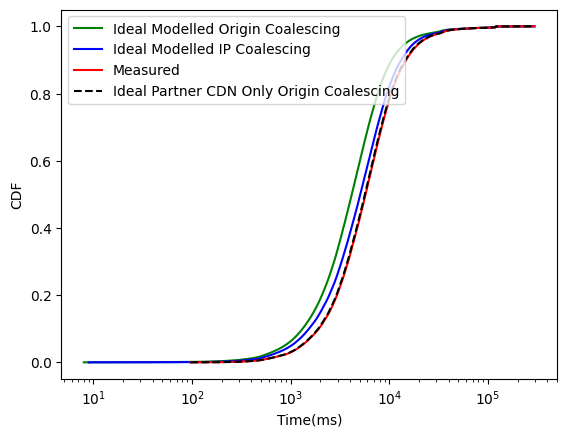

Figure 9b
Control - PLT [P50] = 2421.0
Control - PLT [P75] = 3615.0
Control - PLT [P90] = 5303.600000000004
Control - PLT [P95] = 7079.799999999987
Control - PLT [P99] = 13687.479999999992
Experiment - PLT [P50] = 2412.0
Experiment - PLT [P75] = 3729.0
Experiment - PLT [P90] = 5552.0
Experiment - PLT [P95] = 7159.0
Experiment - PLT [P99] = 12876.799999999977


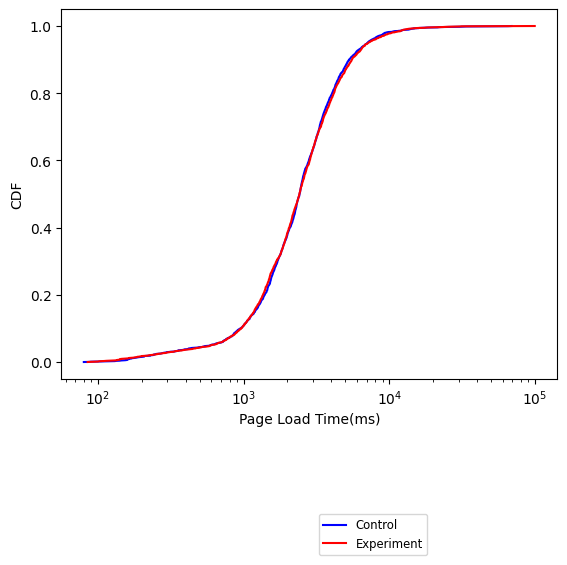

In [10]:
def plot_figure_9a(dataframe_path=f"{DATAFRAME_DIR}/figure-9a-dataframe.csv"):
    df = pandas.read_csv(dataframe_path)
    page_load_times = numpy.array([x for x in df['page_load_times'].tolist() if x != -1])
    ip_page_load_times = numpy.array([x for x in df['ip_page_load_times'].tolist() if x != -1])
    as_page_load_times = numpy.array([x for x in df['as_page_load_times'].tolist() if x != -1])
    cf_only_page_load_times = numpy.array([x for x in df['cf_only_page_load_times'].tolist() if x != -1])

    fig, ax = plt.subplots(nrows=1, ncols=1)
    for arr, label_name, color, ltype in [
        (as_page_load_times, 'Ideal Modelled Origin Coalescing', 'green', '-'),
        (ip_page_load_times, 'Ideal Modelled IP Coalescing', 'blue', '-'),
        (page_load_times, 'Measured', 'red', '-'),
        (cf_only_page_load_times, 'Ideal Partner CDN Only Origin Coalescing', 'black', '--'),
    ]:
        X, Y = _cdf(arr, sort_needed=True)
        for p in [25, 50, 75, 90, 95, 99]:
            print(label_name, p, numpy.percentile(numpy.array(arr), p))
        ax.plot(X, Y, label=label_name, color=color, linestyle=ltype)
    ax.legend()
    ax.set_xscale('log')
    ax.set_ylabel('CDF')
    ax.set_xlabel('Time(ms)')
    plt.show()


def plot_figure_9b(dataframe_path=f"{DATAFRAME_DIR}/figure-9b-dataframe.csv"):
    df = pandas.read_csv(dataframe_path)

    control_plts = []
    experiment_plts = []

    for index, row in df.iterrows():
        split_mode = row['Mode']
        ccv2_plt = row['Time']
        if split_mode == 'Experiment':
            experiment_plts.append(ccv2_plt)
        if split_mode == 'Control':
            control_plts.append(ccv2_plt)

    for (arr, category) in [(control_plts, 'Control - PLT'),
                            (experiment_plts, 'Experiment - PLT')]:
        for p in [50, 75, 90, 95, 99]:
            pct_value = numpy.percentile(arr, p)
            print(f'{category} [P{p}] = {pct_value}')

    fig, ax = plt.subplots(nrows=1, ncols=1)
    control_plt_X, control_plt_Y = _cdf(numpy.array(control_plts))
    exp_plt_X, exp_plt_Y = _cdf(numpy.array(experiment_plts))
    ax.plot(control_plt_X, control_plt_Y, label='Control', color='blue')
    ax.plot(exp_plt_X, exp_plt_Y, label='Experiment', color='red')
    ax.set_xscale('log')
    ax.set_xlabel('Page Load Time(ms)')
    ax.set_ylabel('CDF')
    ax.legend(bbox_to_anchor=(0.75, -0.35), fontsize='small')
    plt.tick_params(axis="x", which="minor")
    plt.show()
    

print('Figure 9a')
plot_figure_9a()
print('Figure 9b')
plot_figure_9b()

Control - PLT [P50] = 2421.0
Control - PLT [P75] = 3615.0
Control - PLT [P90] = 5303.600000000004
Control - PLT [P95] = 7079.799999999987
Control - PLT [P99] = 13687.479999999992
Experiment - PLT [P50] = 2412.0
Experiment - PLT [P75] = 3729.0
Experiment - PLT [P90] = 5552.0
Experiment - PLT [P95] = 7159.0
Experiment - PLT [P99] = 12876.799999999977
I.M. Origin Coalescing 25 2422.0
I.M. Origin Coalescing 50 4167.0
I.M. Origin Coalescing 75 6811.0
I.M. Origin Coalescing 90 10583.0
I.M. Origin Coalescing 95 14707.0
I.M. Origin Coalescing 99 39143.679999999935
I.M. IP Coalescing 25 2885.0
I.M. IP Coalescing 50 5080.0
I.M. IP Coalescing 75 8402.0
I.M. IP Coalescing 90 13219.0
I.M. IP Coalescing 95 17878.0
I.M. IP Coalescing 99 41435.69999999984
Measured 25 3391.0
Measured 50 5746.0
Measured 75 9318.0
Measured 90 14850.799999999988
Measured 95 20361.899999999965
Measured 99 44904.33999999991
I.M. CDN Origin Coalescing 25 3338.0
I.M. CDN Origin Coalescing 50 5661.0
I.M. CDN Origin Coalescing 

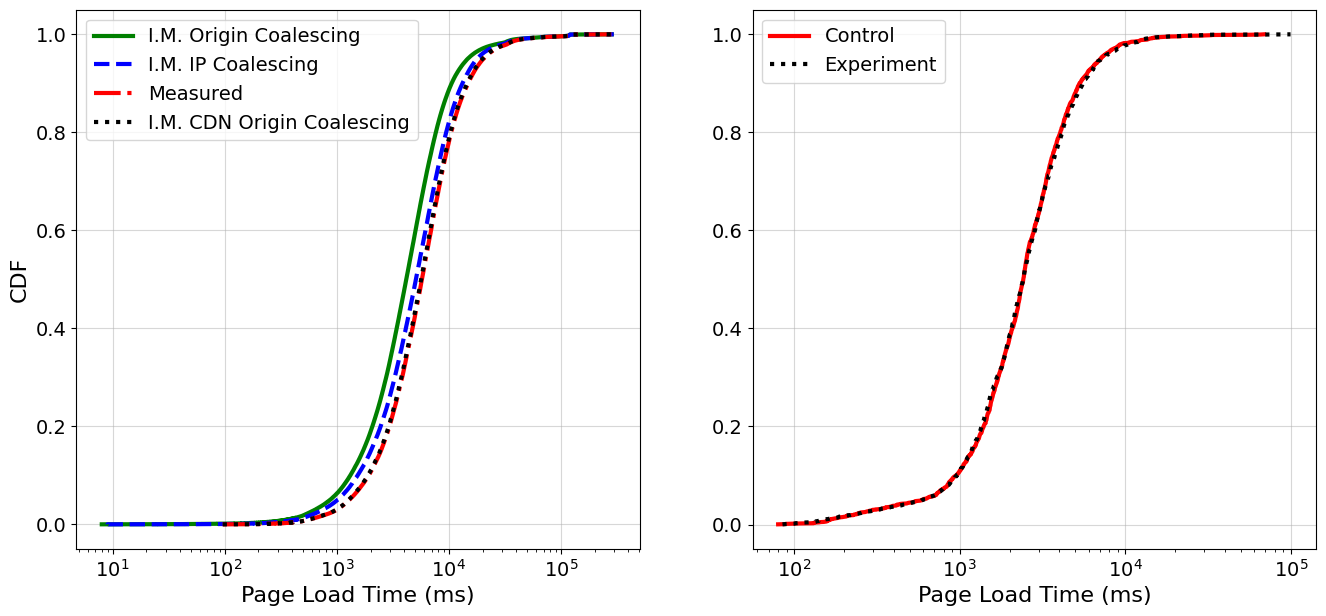

In [5]:
def plot_figure_9(a=f"{DATAFRAME_DIR}/figure-9a-dataframe.csv", b=f"{DATAFRAME_DIR}/figure-9b-dataframe.csv"):
    # 9a
    df = pandas.read_csv(a)
    page_load_times = numpy.array([x for x in df['page_load_times'].tolist() if x != -1])
    ip_page_load_times = numpy.array([x for x in df['ip_page_load_times'].tolist() if x != -1])
    as_page_load_times = numpy.array([x for x in df['as_page_load_times'].tolist() if x != -1])
    cf_only_page_load_times = numpy.array([x for x in df['cf_only_page_load_times'].tolist() if x != -1])
    # 9b
    df = pandas.read_csv(b)

    control_plts = []
    experiment_plts = []

    for index, row in df.iterrows():
        split_mode = row['Mode']
        ccv2_plt = row['Time']
        if split_mode == 'Experiment':
            experiment_plts.append(ccv2_plt)
        if split_mode == 'Control':
            control_plts.append(ccv2_plt)

    for (arr, category) in [(control_plts, 'Control - PLT'),
                            (experiment_plts, 'Experiment - PLT')]:
        for p in [50, 75, 90, 95, 99]:
            pct_value = numpy.percentile(arr, p)
            print(f'{category} [P{p}] = {pct_value}')
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
    for arr, label_name, color, ltype, marker in [
        (as_page_load_times, 'I.M. Origin Coalescing', 'green', '-', 'o'),
        (ip_page_load_times, 'I.M. IP Coalescing', 'blue', '--', '*'),
        (page_load_times, 'Measured', 'red', '-.', '+'),
        (cf_only_page_load_times, 'I.M. CDN Origin Coalescing', 'black', ':', 'v'),
    ]:
        X, Y = _cdf(arr, sort_needed=True)
        for p in [25, 50, 75, 90, 95, 99]:
            print(label_name, p, numpy.percentile(numpy.array(arr), p))
        ax[0].plot(X, Y, label=label_name, color=color, linestyle=ltype, linewidth=3)
    ax[0].legend(fontsize=14)
    ax[0].set_xscale('log')
    ax[0].tick_params(axis='x', labelsize=14)
    ax[0].tick_params(axis='y', labelsize=14)
    ax[0].set_ylabel('CDF', fontsize=16)
    ax[0].set_xlabel('Page Load Time (ms)', fontsize=16)
    ax[0].grid(True, alpha=0.5)
    
    control_plt_X, control_plt_Y = _cdf(numpy.array(control_plts))
    exp_plt_X, exp_plt_Y = _cdf(numpy.array(experiment_plts))
    ax[1].plot(control_plt_X, control_plt_Y, label='Control', color='red', linestyle='-', linewidth=3)
    ax[1].plot(exp_plt_X, exp_plt_Y, label='Experiment', color='black', linestyle=':', linewidth=3)
    ax[1].legend(fontsize=14)
    ax[1].set_xscale('log')
    ax[1].tick_params(axis='x', labelsize=14)
    ax[1].tick_params(axis='y', labelsize=14)
    ax[1].set_xlabel('Page Load Time (ms)', fontsize=16)
    ax[1].grid(True, alpha=0.5)

plot_figure_9()